In [42]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import csv
from scipy.optimize import curve_fit
from IPython.display import clear_output

# Polarization-gradient cooling in a lattice
When an atom or ion is confined (such as in an optical lattice) to the point where its typical spread is smaller than the wavelength of the excitation light, we say we're in the Lamb-Dicke limit. This is typically expressed as $\eta \equiv k z = k \sqrt{\frac{\hbar}{2m\omega}} \ll 1$, where $k$ is the wave vector of the excitation light. The spectrum of the trapped particle will develop sidebands which correspond to transitions between different harmonic oscillator states. What's more, when an excited atom decays, it will not experience a recoil kick, simply "because the momentum has nowhere to go," colloquially speaking. This effect is akin to the Mossbauer effect in nuclear physics.

### The Hamiltonian
The simplest level scheme that exhibits Sisyphus cooling is a $J = 1/2$ ground state, and a $J = 3/2$ excited state. We'll follow the notation of [Cirac _et al._](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.48.1434). We assume a 1D harmonic oscillator with trapping frequency $\omega$. The cooling beams are linearly polarized with an angle $\theta$ between each other, and at $z = 0$ their relative phase is $\phi$. The Hamiltonian consits of two parts; that describing the Harmonic oscillathor 
$$
    \mathcal{H}_\mathrm{ho}/\hbar = \omega \left( n + \frac{1}{2} \right),
$$
and that describing the interaction with the lasers. In the rotating frame and in the interaction picture this is given by:
\begin{align}
    \mathcal{H}_\mathrm{laser}/\hbar =& \frac{\Omega}{\sqrt{2}} \cos\left( kz + \theta/2 + \phi \right) \left[ |e_{3/2}\rangle\langle g_{1/2}| + \frac{1}{\sqrt{3}}|e_{1/2}\rangle\langle g_{-1/2}| \right] - \\
    &\frac{\Omega}{\sqrt{2}} \cos\left( kz - \theta/2 + \phi \right) \left[ |e_{-3/2}\rangle\langle g_{-1/2}| + \frac{1}{\sqrt{3}}|e_{-1/2}\rangle\langle g_{1/2}| \right] - \\
    &\sum\limits_k \Delta |e_k\rangle \langle e_k | + \mathrm{H.c.},
\end{align}
here the sum runs over all excited states $k \in \left\{-3/2, -1/2, 1/2, 3/2 \right\}$.

We can simplify the cosines using 
$$
\cos\left( kz \pm \theta/2 + \phi \right) = \cos\left[ \eta \left(\hat{a} + \hat{a}^\dagger \right) \right] \cos\left( \phi \pm \theta/2 \right) - \sin\left[ \eta \left(\hat{a} + \hat{a}^\dagger \right) \right] \sin\left( \phi \pm \theta/2 \right),
$$
where $\eta$ is the Lamb-Dicke parameter as defined above. Assuming $kz$ is small (which is inherent to us being in the Lamb-Dicke regime), this results in:
\begin{align}
        \mathcal{H}_\mathrm{laser}/\hbar =& \frac{\Omega}{\sqrt{2}} \left[\cos\left( \phi + \theta/2 \right) - \eta \left( \hat{a}^\dagger + \hat{a} \right) \sin\left( \phi + \theta/2 \right) \right] \left[ |e_{3/2}\rangle\langle g_{1/2}| + \frac{1}{\sqrt{3}}|e_{1/2}\rangle\langle g_{-1/2}| \right] - \\
    &\frac{\Omega}{\sqrt{2}} \left[\cos\left( \phi - \theta/2 \right) - \eta \left( \hat{a}^\dagger + \hat{a} \right) \sin\left( \phi - \theta/2 \right) \right] \left[ |e_{-3/2}\rangle\langle g_{-1/2}| + \frac{1}{\sqrt{3}}|e_{-1/2}\rangle\langle g_{1/2}| \right] - \\
    &\sum\limits_k \Delta |e_k\rangle \langle e_k | + \mathrm{H.c.}.
\end{align}
This may look a little daunting, but what we basically have here is a bunch of carrier terms (that do not change the harmonic oscillator state) and some sideband terms (which do change the harmonic oscillator state). By changing the detuning we can decide which get excited, which is exactly the point of this cooling scheme. Below we actually expands the sines and cosines up to arbitrary order; this makes things slightly more accurate, but deep in the Lamb-Dicke regime it does not make a difference.

#### Internal part
Let's set up the Hamiltonian. We'll assume the internal state basis is given by $\left\{ g_{-1/2}, g_{1/2}, e_{-3,2}, e_{-1/2}, e_{1/2}, e_{3/2} \right\}$. We denote the transition matrices with `giej` where `i` and `j` stand for the coupled hyperfine levels.

In [2]:
def couple(a, b, N):
    # Describes coupling between a and b in N-dimensional basis
    dum = np.zeros((N, N))
    dum[a-1, b-1] = 1
    dum[b-1, a-1] = 1
    return Qobj(dum)

idCoupled = np.array([[2, 6], [1, 5], [1, 3], [2, 4]])
couplingMatrices = [];
for ids in idCoupled:
    couplingMatrices.append( couple(ids[0], ids[1], 6 ) )
    
g12e32 = couplingMatrices[0]
gm12e12 = couplingMatrices[1]
gm12em32 = couplingMatrices[2]
g12em12 = couplingMatrices[3]

##### Expanding $\cos\left[ \eta \left(\hat{a} + \hat{a}^\dagger \right) \right]$ and $\sin\left[ \eta \left(\hat{a} + \hat{a}^\dagger \right) \right]$

We do a simple Taylor expansion, i.e.:
\begin{align}
    \cos\left[ \eta \left(\hat{a} + \hat{a}^\dagger \right) \right] &= \sum_{n=1}^\infty \frac{\left( -1 \right)^n}{\left( 2n \right)!} \left[ \eta \left( \hat{a} + \hat{a}^\dagger \right) \right]^{2n} \\
    \sin\left[ \eta \left(\hat{a} + \hat{a}^\dagger \right) \right] &= \sum_{n=1}^\infty \frac{\left( -1 \right)^n}{\left( 2n + 1\right)!} \left[ \eta \left( \hat{a} + \hat{a}^\dagger \right) \right]^{2n + 1}
\end{align}

To set up the $\hat{a} + \hat{a}^\dagger$ term using QuTiP we use the `position()` object, but for that we need a factor $\sqrt{2}$.

In [3]:
def sinkzOp(eta, nmax, nterms):
    operator = np.sqrt(2)*eta*position(nmax)
    for i in range(1, nterms):
        k = 2*i + 1
        operator += (-1)**i * (np.sqrt(2) * eta)**k * position(nmax)**k / np.math.factorial(k)
    return operator

def coskzOp(eta, nmax, nterms):
    operator = qeye(nmax)
    for i in range(1, nterms):
        k = 2*i
        operator += (-1)**i * (np.sqrt(2) * eta)**k * position(nmax)**k / np.math.factorial(k)
    return operator

In the Hamiltonian there are a bunch of terms coupling the internal state, but they only occur in two distinct terms. Let's combine these as a shorthand: `termA` and `termB`, and use these to construct both the direct and sideband couplings:

In [34]:
Gamma = 2*np.pi * 9.8E6       # Going for Na-23
Omega = Gamma
delta = - 10*Gamma
#phi = 0.5 * np.pi # / 2
#theta = 0.5 * np.pi # / 2
eta = 0.22                    # Assuming Na-23 mass
nmax = 40

In [35]:
termA = g12e32 + gm12e12/np.sqrt(3)
termB = gm12em32 + g12em12/np.sqrt(3)
nterms = 30

def Hlaser(phi, theta):
    rabiA = Omega / np.sqrt(2) * tensor( np.cos(phi + theta/2) * coskzOp(eta, nmax, nterms) - np.sin(phi + theta/2) * sinkzOp(eta, nmax, nterms), termA )
    rabiB = -Omega / np.sqrt(2) * tensor( np.cos(phi - theta/2) * coskzOp(eta, nmax, nterms) - np.sin(phi - theta/2) * sinkzOp(eta, nmax, nterms), termB )
    detuning = -delta * tensor(qeye(nmax), Qobj( np.diag([0, 0, 1, 1, 1, 1]) ) )

    return rabiA + rabiB + detuning

#### Harmonic oscillator part

In [36]:
omega = 0.023*Gamma
Hho = omega * ( tensor(num(nmax), qeye(6)) + 1/2 )

def Htot(phi, theta):
    return Hho + Hlaser(phi, theta)

#### Decay processes
In total, there are six decay processes. The thesis by [Renauld Chrétien](https://orbi.uliege.be/handle/2268/212746) provides a useful derivation of all couplings, but since we do not care about momentum transfer, the branching ratios are just given by the Clebsch-Gordan coefficients. 

In [37]:
def decay(a, b, N):
    # Describes decay from state a to state b in N-dimensional basis
    dum = np.zeros((N, N))
    dum[b-1, a-1] = 1
    return Qobj(dum)

Cm32 = np.sqrt(Gamma) * tensor(qeye(nmax), decay(3, 1, 6))
Cm12 = [np.sqrt(2/3 * Gamma) * tensor(qeye(nmax), decay(4, 1, 6)), np.sqrt(1/3 * Gamma) * tensor(qeye(nmax), decay(4, 2, 6))]
C12 = [np.sqrt(2/3 * Gamma) * tensor(qeye(nmax), decay(5, 2, 6)), np.sqrt(1/3 * Gamma) * tensor(qeye(nmax), decay(5, 1, 6))]
C32 = np.sqrt(Gamma) * tensor(qeye(nmax), decay(6, 2, 6))

Ctot = [Cm32, Cm12[0], Cm12[1], C12[0], C12[1], C32]

### Runtime!

In [57]:
observable = tensor(num(nmax), qeye(6))    
ninit = 0
psi0 = tensor(basis(nmax, ninit), Qobj( np.array([1/np.sqrt(2), 1/np.sqrt(2), 0, 0, 0, 0]) ))
timeax = np.linspace(0, 1E-3, 160000)

def sol(phi, theta):
    return mcsolve(Htot(phi, theta), psi0, timeax, e_ops = observable, c_ops = Ctot, ntraj = 500)

In [ ]:
phis = np.array([0.32, 0.34, 0.36, 0.38, 0.4, 0.5])
sols = []
for phi in phis:
    print('phi = %.2f' % phi)
    sols.append( sol(phi*np.pi, 0.5*np.pi) )
    
    # Export
    filename = 'evo_phi_%.2fpi.csv' % phi
    data = np.transpose([timeax, sols[-1].expect[0]])
    with open(filename, 'w', newline = '') as file:
        writer = csv.writer(file, delimiter=',')
        writer.writerow(['time', 'nave'])
        for row in data:
            writer.writerow(row)
    
    clear_output()

phi = 0.32
10.0%. Run time: 714.74s. Est. time left: 00:01:47:12
20.0%. Run time: 1416.94s. Est. time left: 00:01:34:27
30.0%. Run time: 2074.44s. Est. time left: 00:01:20:40
40.0%. Run time: 2748.05s. Est. time left: 00:01:08:42
50.0%. Run time: 3405.57s. Est. time left: 00:00:56:45


Plot:

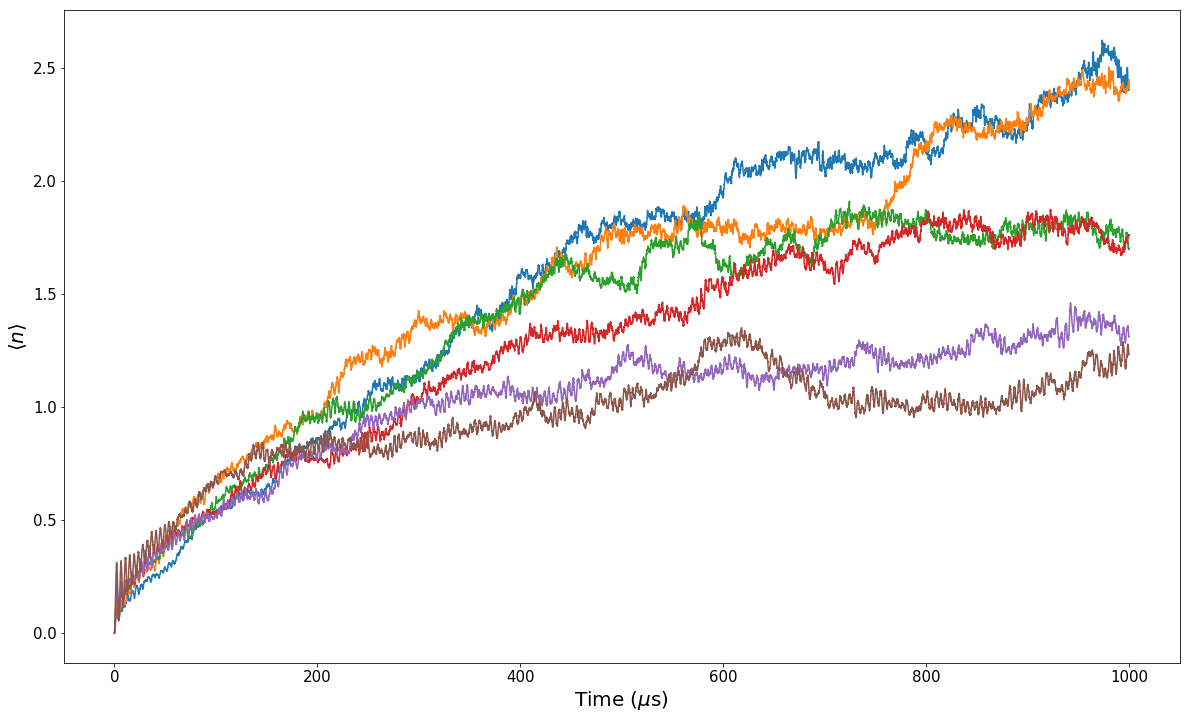

In [56]:
fig, ax = plt.subplots(figsize=(20, 12))
for i in range(len(phis)):
    ax.plot(timeax*1E6, sols[i].expect[0])

ax.set_xlabel(r'Time ($\mu$s)', size = 20)
ax.set_ylabel(r'$\langle n \rangle$', size = 20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

Export:

In [49]:
for i in range(len(phis)):
    filename = 'evo_phi_%.2fpi.csv' % phis[i]
    data = np.transpose([timeax, sols[i].expect[0]])
    with open(filename, 'w', newline = '') as file:
        writer = csv.writer(file, delimiter=',')
        writer.writerow(['time', 'nave'])
        for row in data:
            writer.writerow(row)